In [ ]:
#https://towardsdatascience.com/machine-learning-multiclass-classification-with-imbalanced-data-set-29f6a177c1a

In [1]:
from sklearn.datasets import fetch_20newsgroups
newsgroups_train = fetch_20newsgroups(subset='train')

In [2]:
import pandas as pd

In [3]:
from pprint import pprint
pprint(list(newsgroups_train.target_names))

['alt.atheism',
 'comp.graphics',
 'comp.os.ms-windows.misc',
 'comp.sys.ibm.pc.hardware',
 'comp.sys.mac.hardware',
 'comp.windows.x',
 'misc.forsale',
 'rec.autos',
 'rec.motorcycles',
 'rec.sport.baseball',
 'rec.sport.hockey',
 'sci.crypt',
 'sci.electronics',
 'sci.med',
 'sci.space',
 'soc.religion.christian',
 'talk.politics.guns',
 'talk.politics.mideast',
 'talk.politics.misc',
 'talk.religion.misc']


In [4]:
newsgroups_train.filenames.shape

(11314,)

In [7]:
newsgroups_train.target.shape

(11314,)

In [8]:
cats = ['alt.atheism', 'sci.space']
newsgroups_train1 = fetch_20newsgroups(subset='train', categories=cats)

In [9]:
list(newsgroups_train1.target_names)


['alt.atheism', 'sci.space']

In [10]:
newsgroups_train1.filenames.shape

(1073,)

In [11]:
newsgroups_train1.target.shape

(1073,)

In [12]:
newsgroups_train1.target[:10]

array([0, 1, 1, 1, 0, 1, 1, 0, 0, 0], dtype=int64)

# Converting Text to Vector

In [10]:
from sklearn.feature_extraction.text import TfidfVectorizer
categories = ['alt.atheism', 'talk.religion.misc',
               'comp.graphics', 'sci.space']
newsgroups_train = fetch_20newsgroups(subset='train',
                                      categories=categories)
vectorizer = TfidfVectorizer()
vectors = vectorizer.fit_transform(newsgroups_train.data)
vectors.shape

(2034, 34118)

In [11]:
##The extracted TF-IDF vectors are very sparse, with an average of 159 non-zero components 
##by sample in a more than 30000-dimensional space (less than .5% non-zero features)
vectors.nnz / float(vectors.shape[0])

159.0132743362832

In [19]:
vectors[1].toarray()

array([[0., 0., 0., ..., 0., 0., 0.]])

In [21]:
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics
newsgroups_test = fetch_20newsgroups(subset='test',
                                      categories=categories)
vectors_test = vectorizer.transform(newsgroups_test.data)
clf = MultinomialNB(alpha=.01)
clf.fit(vectors, newsgroups_train.target)
pred = clf.predict(vectors_test)
metrics.f1_score(newsgroups_test.target, pred, average='macro')

0.8821359240272957

In [22]:
import numpy as np
def show_top10(classifier, vectorizer, categories):
    feature_names = np.asarray(vectorizer.get_feature_names())
    for i, category in enumerate(categories):
        top10 = np.argsort(classifier.coef_[i])[-10:]
        print("%s: %s" % (category, " ".join(feature_names[top10])))

show_top10(clf, vectorizer, newsgroups_train.target_names)

alt.atheism: edu it and in you that is of to the
comp.graphics: edu in graphics it is for and of to the
sci.space: edu it that is in and space to of the
talk.religion.misc: not it you in is that and to of the


D:\Users\admin\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:101: FutureWarning: Attribute coef_ was deprecated in version 0.24 and will be removed in 1.1 (renaming of 0.26).
  warnings.warn(msg, category=FutureWarning)


In [59]:
newsgroups_test = fetch_20newsgroups(subset='test',
                                      remove=('headers', 'footers', 'quotes'),
                                      categories=categories)
vectors_test = vectorizer.transform(newsgroups_test.data)
pred = clf.predict(vectors_test)
metrics.f1_score(pred, newsgroups_test.target, average='macro')


0.7731035068127478

In [60]:
#This classifier lost over a lot of its F-score, just because we removed metadata that has little to do with topic classification. 
#It loses even more if we also strip this metadata from the training data

In [24]:
newsgroups_tr= fetch_20newsgroups(subset='train', remove=('header', 'footer', 'quotes'), categories=categories)
vect= vectorizer.fit_transform(newsgroups_train.data)
clf= MultinomialNB(alpha=.01)
clf.fit(vectors, newsgroups_train.target)
vectors_t= vectorizer.transform(newsgroups_test.data)
pred= clf.predict(vectors_test)
metrics.f1_score(newsgroups_test.target, pred, average='macro')

0.8821359240272957

# Using Neural Network

In [74]:
#!pip install keras
#!pip install tensorflow

In [ ]:
import tensorflow as tf
import pandas as pd
import numpy as np
import pickle
from keras.preprocessing.text import Tokenizer
from keras.models import Sequential, Model
from keras.layers import Activation, Dense, Dropout
from sklearn.preprocessing import LabelBinarizer
import sklearn.datasets as skds
from pathlib import Path
import matplotlib.pyplot as plt
import itertools
from sklearn.metrics import confusion_matrix
# For reproducibility
np.random.seed(1237)

In [101]:
# Source file directory
# downlaod from http://qwone.com/~jason/20Newsgroups/

In [93]:
# files_train
# labelled_files
# label_names
# train_files_names
# data['filename']

In [ ]:
path_train = "20news-bydate-train"

files_train = skds.load_files(path_train,load_content=False)

label_index = files_train.target
label_names = files_train.target_names
labelled_files = files_train.filenames

data_tags = ["filename","category","news"]
data_list = []

# Read and add data from file to a list
i=0
for f in labelled_files:
    data_list.append((f,label_names[label_index[i]],Path(f).read_text()))
    i += 1

# We have training data available as dictionary filename, category, data
data = pd.DataFrame.from_records(data_list, columns=data_tags)

# 20 news groups
num_labels = 20
vocab_size = 15000
batch_size = 100
num_epochs = 30

# lets take 80% data as training and remaining 20% for test.
train_size = int(len(data) * .8)

train_posts = data['news'][:train_size]
train_tags = data['category'][:train_size]
train_files_names = data['filename'][:train_size]

test_posts = data['news'][train_size:]
test_tags = data['category'][train_size:]
test_files_names = data['filename'][train_size:]

# define Tokenizer with Vocab Size
tokenizer = Tokenizer(num_words=vocab_size)
tokenizer.fit_on_texts(train_posts)

x_train = tokenizer.texts_to_matrix(train_posts, mode='tfidf')
x_test = tokenizer.texts_to_matrix(test_posts, mode='tfidf')

encoder = LabelBinarizer()
encoder.fit(train_tags)
y_train = encoder.transform(train_tags)
y_test = encoder.transform(test_tags)

In [6]:
data.category.value_counts()

rec.sport.hockey            600
soc.religion.christian      599
rec.motorcycles             598
rec.sport.baseball          597
sci.crypt                   595
sci.med                     594
rec.autos                   594
sci.space                   593
comp.windows.x              593
comp.os.ms-windows.misc     591
sci.electronics             591
comp.sys.ibm.pc.hardware    590
misc.forsale                585
comp.graphics               584
comp.sys.mac.hardware       578
talk.politics.mideast       564
talk.politics.guns          546
alt.atheism                 480
talk.politics.misc          465
talk.religion.misc          377
Name: category, dtype: int64

### create class imbalance; a rough approach. This is just to check how model works

In [7]:
#create class imbalance; my rough approach
data_imb = data.copy()

for i in range(1,6):
    for index, row in data_imb.iterrows():
        if((row["category"] == "alt.atheism"   or row["category"] == "talk.politics.misc" 
            or row["category"] =="soc.religion.christian" 
            or row["category"] == "talk.politics.mideast")and (index % 3) == 0):
            data_imb.drop(index, inplace=True)
        elif((row["category"] == "comp.os.ms-windows.misc"  or row["category"] == "comp.sys.ibm.pc.hardware" or row["category"] == "comp.graphics" 
            or row["category"] =="comp.windows.x" or row["category"] == "comp.sys.mac.hardware")and (index % 4) == 0):
            data_imb.drop(index, inplace=True)
        elif((row["category"] == "sci.med"  or row["category"] == "sci.space" or row["category"] == "sci.electronics" 
            or row["category"] =="sci.crypt" or row["category"] == "misc.forsale") and (index % 5) == 0):
            data_imb.drop(index, inplace=True)

    data_imb.reset_index(drop = True, inplace=True)

In [8]:
data_imb.category.value_counts()

rec.sport.hockey            600
rec.motorcycles             598
rec.sport.baseball          597
rec.autos                   594
talk.politics.guns          546
talk.religion.misc          377
sci.med                     207
sci.electronics             205
sci.space                   197
sci.crypt                   183
misc.forsale                171
comp.os.ms-windows.misc     151
comp.graphics               146
comp.sys.ibm.pc.hardware    137
comp.windows.x              136
comp.sys.mac.hardware       131
soc.religion.christian       86
talk.politics.mideast        67
alt.atheism                  63
talk.politics.misc           55
Name: category, dtype: int64

In [9]:
class_labels = data_imb.category.tolist()

In [95]:
data_imb.head()

,filename,category,news
0,20news-bydate-train\rec.sport.baseball\102736,rec.sport.baseball,From: cubbie@garnet.berkeley.edu ( ...
1,20news-bydate-train\comp.sys.mac.hardware\50485,comp.sys.mac.hardware,From: gnelson@pion.rutgers.edu (Gregory Nelson...
2,20news-bydate-train\sci.crypt\15246,sci.crypt,From: crypt-comments@math.ncsu.edu\nSubject: C...
3,20news-bydate-train\comp.sys.mac.hardware\51904,comp.sys.mac.hardware,From: ()\nSubject: Re: Quadra SCSI Problems??...
4,20news-bydate-train\alt.atheism\53144,alt.atheism,From: keith@cco.caltech.edu (Keith Allan Schne...


In [10]:
# 20 news groups
num_labels = 20
vocab_size = 15000
batch_size = 100
num_epochs = 30

# lets take 80% data as training and remaining 20% for test.
train_size = int(len(data_imb) * .8)

train_posts = data_imb['news'][:train_size]
train_tags = data_imb['category'][:train_size]
train_files_names = data_imb['filename'][:train_size]

test_posts = data_imb['news'][train_size:]
test_tags = data_imb['category'][train_size:]
test_files_names = data_imb['filename'][train_size:]

# define Tokenizer with Vocab Size
tokenizer = Tokenizer(num_words=vocab_size)
tokenizer.fit_on_texts(train_posts)

x_train = tokenizer.texts_to_matrix(train_posts)
x_test = tokenizer.texts_to_matrix(test_posts)

encoder = LabelBinarizer()
encoder.fit(train_tags)
y_train = encoder.transform(train_tags)
y_test = encoder.transform(test_tags)

In [97]:
x_train.shape, y_train.shape

((4197, 15000), (4197, 20))

In [11]:
#let us build a basic model
model = Sequential()
model.add(Dense(512, input_shape=(vocab_size,)))
model.add(Activation('relu'))
model.add(Dropout(0.3))
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.3))
model.add(Dense(num_labels))
model.add(Activation('softmax'))
model.summary()

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 512)               7680512   
_________________________________________________________________
activation (Activation)      (None, 512)               0         
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               262656    
_________________________________________________________________
activation_1 (Activation)    (None, 512)               0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 20)                1

In [12]:
num_epochs =10
batch_size = 128
history = model.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=num_epochs,
                    verbose=2,
                    validation_split=0.2)

Epoch 1/10
27/27 - 17s - loss: 2.1176 - accuracy: 0.4355 - val_loss: 1.1044 - val_accuracy: 0.7500
Epoch 2/10
27/27 - 2s - loss: 0.5873 - accuracy: 0.8704 - val_loss: 0.5165 - val_accuracy: 0.8726
Epoch 3/10
27/27 - 2s - loss: 0.1289 - accuracy: 0.9777 - val_loss: 0.4167 - val_accuracy: 0.8881
Epoch 4/10
27/27 - 2s - loss: 0.0308 - accuracy: 0.9988 - val_loss: 0.4068 - val_accuracy: 0.8845
Epoch 5/10
27/27 - 2s - loss: 0.0142 - accuracy: 0.9994 - val_loss: 0.3657 - val_accuracy: 0.9000
Epoch 6/10
27/27 - 2s - loss: 0.0064 - accuracy: 1.0000 - val_loss: 0.3473 - val_accuracy: 0.8988
Epoch 7/10
27/27 - 2s - loss: 0.0226 - accuracy: 0.9991 - val_loss: 0.4450 - val_accuracy: 0.9024
Epoch 8/10
27/27 - 2s - loss: 0.0050 - accuracy: 1.0000 - val_loss: 0.3622 - val_accuracy: 0.8988
Epoch 9/10
27/27 - 2s - loss: 0.0027 - accuracy: 1.0000 - val_loss: 0.3640 - val_accuracy: 0.8988
Epoch 10/10
27/27 - 2s - loss: 0.0019 - accuracy: 1.0000 - val_loss: 0.3574 - val_accuracy: 0.9012


In [13]:
score, acc = model.evaluate(x_test, y_test,
                       batch_size=batch_size, verbose=2)

print('Test accuracy:', acc)

9/9 - 0s - loss: 0.4779 - accuracy: 0.8876
Test accuracy: 0.8876190185546875


# Another approach using GRU model, takes longer time

In [14]:
from tensorflow.python.keras.preprocessing.text import Tokenizer
from tensorflow.python.keras.preprocessing.sequence import pad_sequences

tokenizer_obj = Tokenizer()

tokenizer_obj.fit_on_texts(train_posts) 

# pad sequences
max_length = max([len(s.split()) for s in train_posts])

# define vocabulary size
vocab_size = len(tokenizer_obj.word_index) + 1

X_train_tokens =  tokenizer_obj.texts_to_sequences(train_posts)
X_test_tokens = tokenizer_obj.texts_to_sequences(test_posts)


X_train_pad = pad_sequences(X_train_tokens, maxlen=max_length, padding='post')
X_test_pad = pad_sequences(X_test_tokens, maxlen=max_length, padding='post')

encoder = LabelBinarizer()
encoder.fit(train_tags)
y_train = encoder.transform(train_tags)
y_test = encoder.transform(test_tags)

In [106]:
#NotImplementedError: Cannot convert a symbolic Tensor (lstm/strided_slice:0) to a numpy array. 
#This error may indicate that you're trying to pass a Tensor to a NumPy call, which is not supported
#!pip install numpy==1.19.5

In [1]:
np.__version__ ##Version 1.19.5 is ok. higher version will create GRU problem

'1.19.5'

In [117]:
tf.__version__

'2.5.0'

In [16]:
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, GRU
from keras.layers.embeddings import Embedding

EMBEDDING_DIM = 100

print('Build model...')

model = Sequential()
model.add(Embedding(vocab_size, EMBEDDING_DIM, input_length=max_length))
model.add(GRU(units=32,  dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(num_labels, activation='softmax'))

# try using different optimizers and different optimizer configs
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

print('Summary of the built model...')
print(model.summary())

Build model...
Summary of the built model...
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 11821, 100)        7199100   
_________________________________________________________________
gru (GRU)                    (None, 32)                12864     
_________________________________________________________________
dense_3 (Dense)              (None, 20)                660       
Total params: 7,212,624
Trainable params: 7,212,624
Non-trainable params: 0
_________________________________________________________________
None


Actual label:sci.med
Predicted label: comp.windows.x
Actual label:sci.crypt
Predicted label: comp.windows.x
Actual label:rec.motorcycles
Predicted label: comp.windows.x
Actual label:comp.sys.mac.hardware
Predicted label: comp.windows.x
Actual label:talk.politics.guns
Predicted label: comp.windows.x
Actual label:soc.religion.christian
Predicted label: comp.windows.x
Actual label:comp.graphics
Predicted label: comp.windows.x
Actual label:rec.sport.baseball
Predicted label: comp.windows.x
Actual label:talk.politics.guns
Predicted label: comp.windows.x
Actual label:rec.motorcycles
Predicted label: comp.windows.x
Normalized confusion matrix


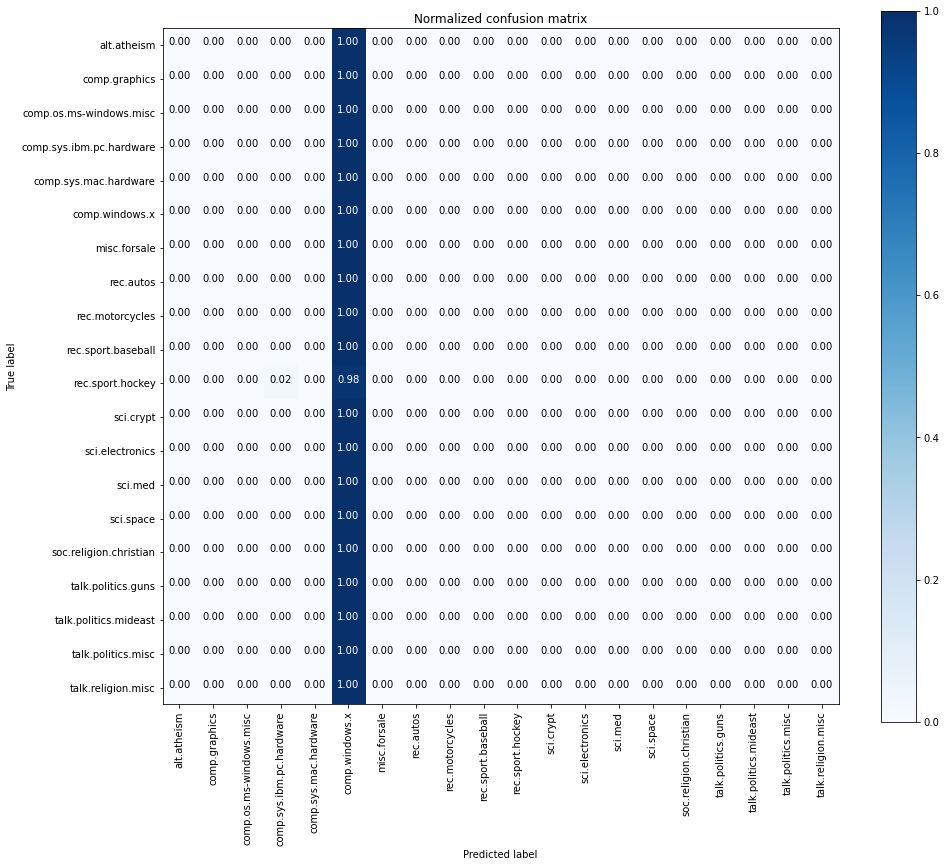

In [17]:
text_labels = encoder.classes_

for i in range(10):
    prediction = model.predict(np.array([x_test[i]]))
    predicted_label = text_labels[np.argmax(prediction[0])]
    #print(test_files_names.iloc[i])
    print('Actual label:' + test_tags.iloc[i])
    print("Predicted label: " + predicted_label)

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    # print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


y_pred = model.predict(x_test);
cnf_matrix = confusion_matrix(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1))

# Plot normalized confusion matrix
fig = plt.figure()
fig.set_size_inches(14, 12, forward=True)
#fig.align_labels()

# fig.subplots_adjust(left=0.0, right=1.0, bottom=0.0, top=1.0)
plot_confusion_matrix(cnf_matrix, classes=np.asarray(label_names), normalize=True,
                      title='Normalized confusion matrix')

fig.savefig("txt_classification-smote" + str(num_epochs) + ".png", pad_inches=5.0)

In [18]:
prediction = model.predict(x_test)

In [19]:
predictions = np.argmax(prediction, axis = 1)

In [20]:
y_test_labels = np.argmax(y_test, axis =1)

In [21]:
y_train_labels = np.argmax(y_train, axis =1)
y_train_labels

array([ 9,  4, 11, ...,  9, 14, 16], dtype=int64)

In [22]:
#The Kappa score tell you how much better, or worse, your classifier is than what would be expected by random chance. 
#If you were to randomly assign cases to classes (i.e. a kind of terribly uninformed classifier), you'd get some correct simply by chance. 
#Therefore, you will always find that the Kappa value is lower than the overall accuracy. 
#The Kappa index is however considered to be a more conservative measure than the overall classification accuracy. 
#Your KIA value is telling you essentially that your classifier is about 66% better than a random assignment of cases to the various classes. That's not bad!
#A kappa value of 1 represents perfect agreement, while a value of 0 represents no agreement.

from sklearn.metrics import cohen_kappa_score
cohen_score = cohen_kappa_score(y_test_labels, predictions)

In [24]:
cohen_score

-9.300681740098682e-06

In [25]:
from sklearn.metrics import precision_recall_fscore_support as score

precision, recall, fscore, support = score(y_test_labels, predictions)

print('precision: {}'.format(precision))
print('recall: {}'.format(recall))
print('fscore: {}'.format(fscore))
print('support: {}'.format(support))

precision: [0.         0.         0.         0.         0.         0.02480916
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.        ]
recall: [0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
fscore: [0.         0.         0.         0.         0.         0.04841713
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.        ]
support: [ 12  29  29  31  25  26  35 108 117 121 124  31  45  43  38  20 103  14
  18  81]


D:\Users\admin\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [26]:
from sklearn.metrics import confusion_matrix
import numpy as np


cm = confusion_matrix(y_test_labels, predictions)
recall = np.diag(cm) / np.sum(cm, axis = 1)
precision = np.diag(cm) / np.sum(cm, axis = 0)

print(recall)

print(precision)

[0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[       nan        nan        nan 0.                nan 0.02480916
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan]


<ipython-input-26-44436477af49>:7: RuntimeWarning: invalid value encountered in true_divide
  precision = np.diag(cm) / np.sum(cm, axis = 0)


In [28]:
#Let us try some sampling technique to remove class imbalance
from imblearn.over_sampling import SMOTE
#Over-sampling: SMOTE
#SMOTE (Synthetic Minority Oversampling TEchnique) consists of synthesizing elements for the minority class, 
#based on those that already exist. It works randomly picking a point from the minority class and computing 
#the k-nearest neighbors for this point.The synthetic points are added between the chosen point and its neighbors.
#We'll use ratio='minority' to resample the minority class.
smote = SMOTE('minority')

X_sm, y_sm = smote.fit_sample(x_train, y_train)
print(X_sm.shape, y_sm.shape)

D:\Users\admin\anaconda3\lib\site-packages\imblearn\utils\_validation.py:587: FutureWarning: Pass sampling_strategy=minority as keyword args. From version 0.9 passing these as positional arguments will result in an error
  warnings.warn(


AttributeError: 'SMOTE' object has no attribute 'fit_sample'